In [87]:
import numpy as np
import pandas as pd
import gudhi

In [88]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.collections import PatchCollection

In [89]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits


from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn import metrics


In [90]:
#import datashader as ds, datashader.transfer_functions as tf, numpy as np

In [91]:
%matplotlib inline

In [92]:
#iris = load_iris()

#pca = PCA(n_components=2)
#pca_iris_points = pca.fit_transform(iris.data)

(1797, 64)


<Figure size 432x288 with 0 Axes>

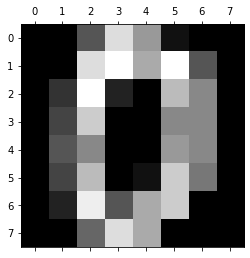

In [94]:
digits = load_digits()
print(digits.data.shape)

plt.gray()
plt.matshow(digits.images[0])

plt.show()

In [95]:
pca = PCA(n_components=5)
pca_digits_points = pca.fit_transform(digits.data)

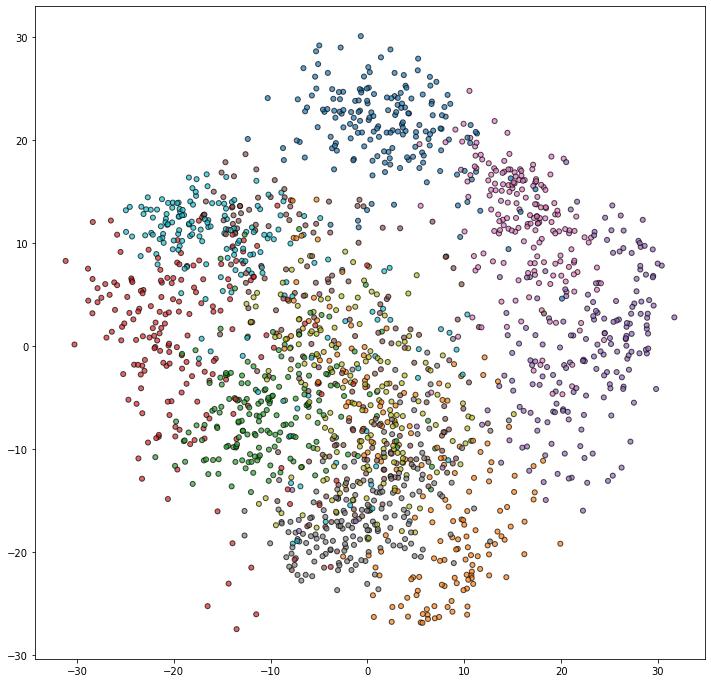

In [96]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(pca_digits_points[:, 0], pca_digits_points[:, 1],
            s=25, 
            c=digits.target,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [8]:
n = 6
std = np.random.random_sample((n,))
#std = 1/n
X, y, z = make_blobs(
    n_samples=200,
    n_features=2,
    centers=n,
    cluster_std=std,
    center_box=(-10.0, 10.0),
    shuffle=False,
    random_state=42,
    return_centers=True,
)

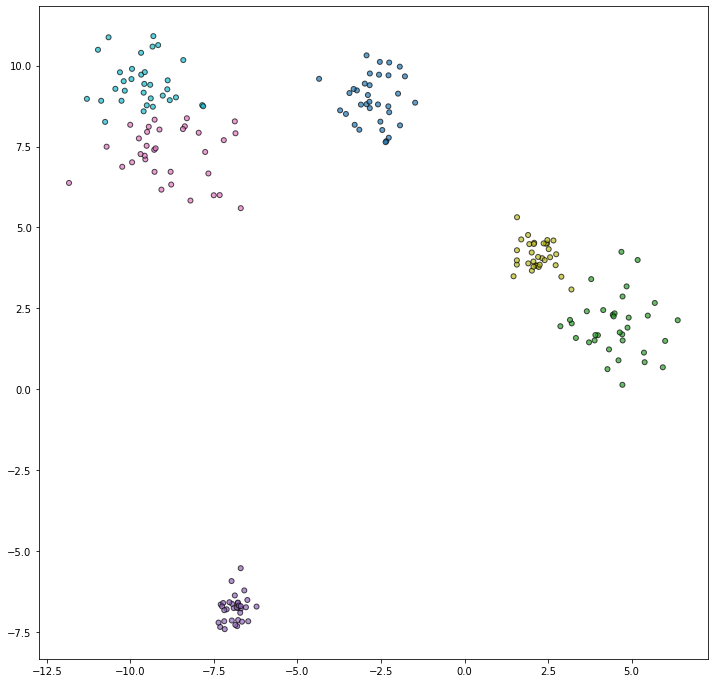

In [9]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=25, 
            c=y,
            marker="o",
            cmap='tab10',
            norm=None,
            alpha=.7,
            edgecolor="k")

In [97]:
def pogo(dataset):
    rips_complex = gudhi.RipsComplex(points=dataset,max_edge_length=100)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)
    df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])
    #move through list and assign clusters to conected components

    point_dict={i:0 for i in range(simplex_tree.num_vertices())}
    counter=0

    cluster_dict_list = []
    for i in range(simplex_tree.num_vertices()+1,len(df)):
        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())
        #print(point_dict)
        #print('step',i)

    
    cutoff_value = 0
    for i in range(len(cluster_dict_list)):
        if cutoff_value == 0:
            if all(value != 0 for value in cluster_dict_list[i].values()):
                cutoff_value = i
                print('dataset becomes connected at simplex #',cutoff_value)
       
    df = df[:cutoff_value]
    #cluster_dict_list =
    
    #find the gaps between birth/death pairs

    df['gaps'] = df['distance'] - df['distance'].shift(1)
    
    #find normalized distance
    scaler = MinMaxScaler()
    df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

    #Mulitply the gaps by their normed location in the filtration, weighting features more heavily if they're later
    df['normed_gaps'] = df['gaps'] * df['normed_distance']

    norm_sum = df['normed_gaps'].sum()
    df['probability_vector_normed_gaps'] = df['normed_gaps'] / norm_sum
    
    gap_sum = df['gaps'].sum()
    df['probability_vector_gaps'] = df['normed_gaps'] / gap_sum

    partition = 10
    candidates = [i for i in df.nlargest(partition ,['gaps']).index if i in df.nlargest( partition,['normed_gaps']).index]
    #print('possible cuttoffs' , candidates)
    idx = cutoff_value
    #idx = candidates[0]
    print('idx' ,idx)

    print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

    #print( np.array(list(cluster_dict_list[idx].values())))

    print(simplex_tree.num_vertices() , 'vertices')  
    print(simplex_tree.num_simplices(), 'simplices')
    print('dimension:', simplex_tree.dimension())

    size=10
    plt.figure(figsize=(size,size))
    plt.scatter(dataset[:, 0], dataset[:, 1],
                s=30, 
                c=np.array(list(cluster_dict_list[idx].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=.9,
                edgecolor="k")
    
    return cluster_dict_list, candidates, idx


dataset becomes connected at simplex # 2530
idx 2530
your dataset appears to have 4 clusters
200 vertices
20100 simplices
dimension: 1


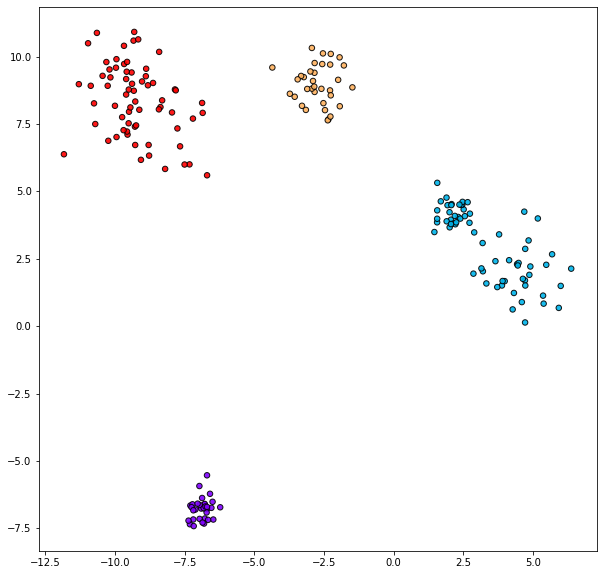

In [11]:
cluster_dict_list, candidates, idx = pogo(X)

In [12]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))


adjusted rand score = 0.6799936637161345


In [ ]:
cluster_dict_list, candidates, idx = pogo(pca_digits_points)

In [14]:
true = digits.target
pred = np.array(list(cluster_dict_list[idx].values()))

print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))


NameError: name 'digits' is not defined

In [15]:
rips_complex = gudhi.RipsComplex(points=X,
                                 max_edge_length=100)

simplex_tree = rips_complex.create_simplex_tree(max_dimension=1)


#for i in simplex_tree.get_filtration():
#    print(i)
    
print(simplex_tree.num_vertices() , 'vertices')  
print(simplex_tree.num_simplices(), 'simplices')
print('dimension:', simplex_tree.dimension())


200 vertices
20100 simplices
dimension: 1


In [16]:
#simplex_tree.prune_above_filtration(100)

In [17]:
#fmt = '%s -> %.8f'
#for filtered_value in simplex_tree.get_skeleton(1):
#    print(fmt % tuple(filtered_value))

In [57]:
#convert the simplex tree to a pandas dataframe
df = pd.DataFrame(simplex_tree.get_filtration(), columns=['simplex','distance'])

In [58]:
#point_dict={i:0 for i in range(simplex_tree.num_vertices())}
#point_dict.values()
#point_dict.values() == 0
#all(point_dict.values()) == 0

In [59]:
#df[100:200]

In [60]:
#move through list and assign clusters to conected components

point_dict={i:0 for i in range(simplex_tree.num_vertices())}
counter=0

cluster_dict_list = []

for i in range(simplex_tree.num_vertices()+1,len(df)):
    if any(value ==0 for value in point_dict.values()):


        #if both points are still in cluster 0, assign both to a new cluster
        if point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            counter += 1
            point_dict[df.loc[i,'simplex'][0]] = counter
            point_dict[df.loc[i,'simplex'][1]] = counter
            #if one point is in cluster 0 and one is not, assign the one in cluster 0 to the existing cluster
        elif point_dict[df.loc[i,'simplex'][0]] == 0 and point_dict[df.loc[i,'simplex'][1]] != 0:
            point_dict[df.loc[i,'simplex'][0]] = point_dict[df.loc[i,'simplex'][1]]

            #and vice versa
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] == 0:
            point_dict[df.loc[i,'simplex'][1]] = point_dict[df.loc[i,'simplex'][0]]

            #if both points are not in cluster 0 and not in the same cluster, merge clusters to the lower number cluster
        elif point_dict[df.loc[i,'simplex'][0]] != 0 and point_dict[df.loc[i,'simplex'][1]] != 0 and point_dict[df.loc[i,'simplex'][0]] != point_dict[df.loc[i,'simplex'][1]]:
            larger_cluster_number = max(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            smaller_cluster_number = min(point_dict[df.loc[i,'simplex'][0]], point_dict[df.loc[i,'simplex'][1]])
            for key, value in point_dict.items():
                if value == larger_cluster_number:
                    point_dict[key] = smaller_cluster_number
        cluster_dict_list.append(point_dict.copy())


In [61]:
len(cluster_dict_list)

2531

In [62]:
cluster_dict_list[-1]

{0: 4,
 1: 4,
 2: 4,
 3: 4,
 4: 4,
 5: 4,
 6: 4,
 7: 4,
 8: 4,
 9: 4,
 10: 4,
 11: 4,
 12: 4,
 13: 4,
 14: 4,
 15: 4,
 16: 4,
 17: 4,
 18: 4,
 19: 4,
 20: 4,
 21: 4,
 22: 4,
 23: 4,
 24: 4,
 25: 4,
 26: 4,
 27: 4,
 28: 4,
 29: 4,
 30: 4,
 31: 4,
 32: 4,
 33: 4,
 34: 2,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 39: 2,
 40: 2,
 41: 2,
 42: 2,
 43: 2,
 44: 2,
 45: 2,
 46: 2,
 47: 2,
 48: 2,
 49: 2,
 50: 2,
 51: 2,
 52: 2,
 53: 2,
 54: 2,
 55: 2,
 56: 2,
 57: 2,
 58: 2,
 59: 2,
 60: 2,
 61: 2,
 62: 2,
 63: 2,
 64: 2,
 65: 2,
 66: 2,
 67: 2,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 5,
 102: 5,
 103: 5,
 104: 5,
 105: 5,
 106: 5,
 107: 5,
 108: 5,
 109: 5,
 110: 5,
 111: 5,
 112: 5,
 113: 5,
 114: 5,
 115: 5,
 116: 5,
 117: 5,
 118: 5,
 119: 5,
 120: 5,
 121: 5,
 122: 5,
 12

In [53]:
#find cutoff in cluster dict list where all clusters merge to 1, then cutoff there for the prob vector

In [63]:
cutoff_value = 0
for i in range(len(cluster_dict_list)):
    if cutoff_value == 0:
        if all(value !=0 for value in cluster_dict_list[i].values()):
            cutoff_value = i
            print(cutoff_value)
        

2530


In [71]:
df = df[:len(cluster_dict_list)]

In [72]:
#find the gaps between birth/death pairs
df['gaps'] = df['distance'] - df['distance'].shift(1)

In [73]:
#find normalized distance
scaler = MinMaxScaler()
df['normed_distance'] = scaler.fit_transform(df['distance'].values.reshape(-1, 1))

In [74]:
df['normed_gaps'] = df['gaps'] * df['normed_distance']

In [75]:
sum = df['normed_gaps'].sum()
#print(sum)
df['probability_vector'] = df['normed_gaps'] / sum

In [76]:
#sum(df.loc[:,'probability_vector'])

In [77]:
df.nlargest( 60,['probability_vector'])

,simplex,distance,gaps,normed_distance,normed_gaps,probability_vector
2419,"[137, 146]",1.384077,0.003620,0.946040,0.003425,0.004677
2246,"[115, 172]",1.282869,0.003790,0.876862,0.003323,0.004538
2435,"[173, 191]",1.399165,0.002861,0.956352,0.002736,0.003736
2225,"[48, 63]",1.268213,0.003056,0.866845,0.002649,0.003617
2448,"[116, 125]",1.409176,0.002658,0.963195,0.002560,0.003495
1842,"[115, 190]",1.033961,0.003618,0.706730,0.002557,0.003492
2470,"[114, 196]",1.427820,0.002609,0.975939,0.002547,0.003477
2219,"[101, 110]",1.262641,0.002810,0.863036,0.002426,0.003312
2067,"[9, 21]",1.168202,0.002842,0.798485,0.002270,0.003099
1947,"[18, 22]",1.093930,0.002944,0.747720,0.002201,0.003006


In [78]:
df.nlargest( 60,['gaps'])

,simplex,distance,gaps,normed_distance,normed_gaps,probability_vector
200,"[68, 83]",0.016972,0.016972,0.011601,0.000197,0.000269
201,"[71, 93]",0.030360,0.013388,0.020752,0.000278,0.000379
207,"[140, 143]",0.057103,0.010221,0.039031,0.000399,0.000545
265,"[152, 160]",0.150922,0.007884,0.103158,0.000813,0.001111
202,"[145, 147]",0.037709,0.007349,0.025775,0.000189,0.000259
247,"[70, 93]",0.126227,0.006131,0.086279,0.000529,0.000722
214,"[75, 87]",0.074264,0.005117,0.050761,0.000260,0.000355
205,"[183, 185]",0.044329,0.004218,0.030299,0.000128,0.000174
210,"[105, 130]",0.061666,0.004083,0.042149,0.000172,0.000235
221,"[71, 96]",0.084097,0.003919,0.057481,0.000225,0.000308


In [79]:
df.nlargest( 100,['gaps']).index[0]

200

In [80]:
candidates = [i for i in df.nlargest( 20,['gaps']).index if i in df.nlargest( 20,['probability_vector']).index]
candidates

[200,
 201,
 207,
 265,
 202,
 247,
 214,
 205,
 210,
 221,
 223,
 211,
 2246,
 2419,
 1842,
 739,
 226,
 349,
 297,
 272,
 363,
 212,
 546,
 1074,
 645,
 2225,
 721,
 1947,
 1632,
 259,
 708,
 1328,
 2435,
 428,
 2067,
 382,
 2219,
 318,
 2016,
 310,
 601,
 1821,
 327,
 1422,
 2448,
 2037,
 1555,
 2470,
 237,
 206,
 227,
 1685,
 2170,
 1974,
 1861,
 2146,
 235,
 1232,
 1073,
 473,
 1730,
 512,
 317,
 474,
 1018,
 1944,
 2391,
 236,
 2322,
 556,
 1415,
 239,
 2302,
 1412,
 523,
 232,
 243,
 375,
 262,
 1998,
 244,
 2399,
 366,
 2442,
 560,
 433,
 2424,
 278,
 489,
 2179,
 219,
 1890,
 1612,
 204,
 1847,
 284,
 2262,
 1452,
 1510,
 629,
 662,
 387,
 2209,
 1035,
 1503,
 1671,
 1763,
 761,
 551,
 840,
 2185,
 1393,
 358,
 332,
 263,
 373,
 1613,
 2423,
 1567,
 586,
 815,
 2114,
 2433,
 2530,
 846,
 495,
 598,
 562,
 449,
 1799,
 2166,
 1774,
 443,
 348,
 258,
 541,
 1758,
 808,
 2133,
 697,
 2093,
 2139,
 287,
 2175,
 1849,
 2337,
 1003,
 1916,
 1292,
 1807,
 340,
 1143,
 1885,
 380,
 14

In [35]:
#candidates.sort()

In [36]:
idx = max(candidates)
print(idx)

2511


In [81]:
idx = cutoff_value
print(idx)

2530


In [82]:

np.array(list(cluster_dict_list[idx].values()))


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5])

In [83]:

print('your dataset appears to have', len(np.unique(np.array(list(cluster_dict_list[idx].values())))),'clusters')

your dataset appears to have 4 clusters


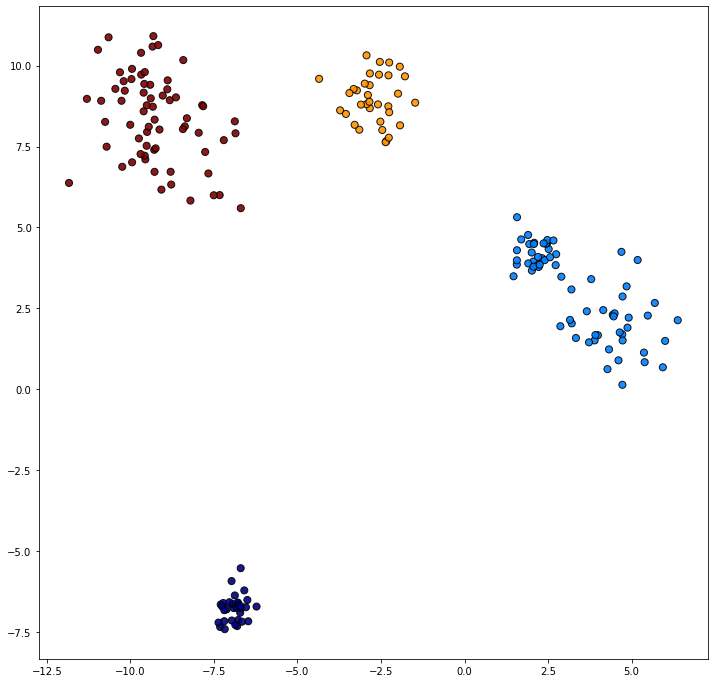

In [84]:
size=12
plt.figure(figsize=(size,size))
plt.scatter(X[:, 0], X[:, 1],
            s=50, 
            c=np.array(list(cluster_dict_list[idx].values())),
            marker="o",
            cmap='jet',
            norm=None,
            alpha=.9,
            edgecolor="k")

In [85]:
true = y
pred = np.array(list(cluster_dict_list[idx].values()))

metrics.adjusted_rand_score(true, pred)


0.6799936637161345

In [42]:
#cluster_dict_list, candidates, idx = pogo(iris.data)

In [43]:
#true = iris.target
#pred = np.array(list(cluster_dict_list[idx].values()))

#print('adjusted rand score =' , metrics.adjusted_rand_score(true, pred))


In [44]:
%matplotlib notebook

<IPython.core.display.Javascript object>


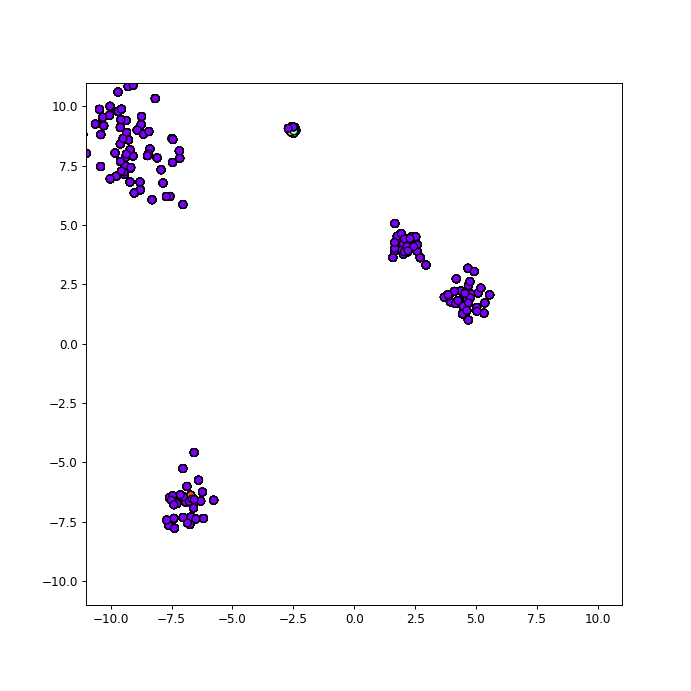

In [45]:
fig, ax = plt.subplots(figsize=(8,8))


def init():
    scatter = ax.scatter(X[:, 0], X[:, 1],
                    s=40, 
                    c=np.array(list(cluster_dict_list[0].values())),
                    marker="o",
                    cmap='rainbow',
                    norm=None,
                    alpha=1,
                    edgecolor="k")
    ax.set(xlim=(-11, 11), ylim=(-11, 11))

    return scatter,

#collection = PatchCollection(X, animated=True)

#ax.add_collection(collection)
#ax.autoscale_view(True)

def animate(i):

    scatter = ax.scatter(X[:, 0], X[:, 1],
                s=40, 
                c=np.array(list(cluster_dict_list[i].values())),
                marker="o",
                cmap='rainbow',
                norm=None,
                alpha=1,
                edgecolor="k")
    return scatter,
    
    
    
ani = FuncAnimation(fig, animate,interval=20,init_func=init,frames=20,repeat=False, blit=True)

#ani.save('animation.gif')



writer=animation.PillowWriter()

writer = animation.FFMpegWriter(fps=20,bitrate=1000)

ani.save('animation.mp4', writer=writer, dpi=250)

plt.show()
